In [1]:
%pip install -U pandas

Requirement already up-to-date: pandas in /opt/conda/lib/python3.7/site-packages (0.25.1)
Note: you may need to restart the kernel to use updated packages.


In [164]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import requests
from bs4 import BeautifulSoup
from urllib.parse import urlparse, urlencode
import pickle
from pathlib import Path

# Base EU6D data

In [211]:
# path to the data
src = Path("./data/euro-6d-temp-modelle.pickle")

# Create dir if it does not exists
if not src.parent.exists(): 
    src.parent.mkdir()

# Try to update the data
try:
    res = pd.read_html("https://www.adac.de/rund-ums-fahrzeug/auto-kaufen-verkaufen/neuwagenkauf/euro-6d-temp-modelle", header=0)
except:
    with open(src, "rb") as _output:
        res = pickle.load(_output)
else:
    with open(src, "wb") as _input:
        pickle.dump(res, _input)

*res* is a list of Dataframes

In [212]:
res[0].head(1)

,Hersteller,Modell,Motorart,Hubraum in ccm,Leistung in KW,Abgasnorm,Markt- einführung
0,Abarth,595,Otto,1368,107,Euro 6d-TEMP-EVAP,Sep. 18


In [213]:
res[1].head(1)

,Hersteller,Modell,Motorart,Hubraum in ccm,Leistung in KW,Abgasnorm,Markt- einführung
0,Alfa Romeo,Giulia 2.0 Turbo 16V,Otto,1955,147,Euro 6d-TEMP,Sep. 18


Concatenate all tables and reindex 

In [214]:
df = pd.concat((elt for elt in res), ignore_index=True)
df.rename({
    'Markt-  einführung': 'Markteinfuehrung',
    'Hubraum in ccm': 'Hubraum',
    'Leistung in KW': 'Leistung'
    }, axis=1, inplace=True)

In [215]:
df.sample(5)

,Hersteller,Modell,Motorart,Hubraum,Leistung,Abgasnorm,Markteinfuehrung
1765,Mercedes,SL 500,Otto,4663,335,Euro 6d-TEMP,Aug. 18
2490,Volvo,V40 Cross Country D2,Diesel,1969,88,Euro 6d-TEMP-EVAP,Mrz. 18
2369,Skoda,Rapid 1.0 TSI,Otto,999,81,Euro 6d-TEMP,Aug. 18
1118,Jaguar,XF 25t,Otto,1997,184,Euro 6d-TEMP,Sep. 18
469,BMW,530i Touring,Otto,1998,185,Euro 6d-TEMP-EVAP-ISC,Jul. 19


In [216]:
df.describe().astype(int)

,Hubraum,Leistung
count,2874,2874
mean,2062,157
std,878,92
min,195,44
25%,1499,95
50%,1969,132
75%,1998,190
max,6749,566


# Data types, memory, column manipulation

In [217]:
df.dtypes

Hersteller          object
Modell              object
Motorart            object
Hubraum              int64
Leistung             int64
Abgasnorm           object
Markteinfuehrung    object
dtype: object

In [218]:
df.memory_usage()

Index                 128
Hersteller          22992
Modell              22992
Motorart            22992
Hubraum             22992
Leistung            22992
Abgasnorm           22992
Markteinfuehrung    22992
dtype: int64

Convert *Markteinfuehrung* col to datetime

For date manipulation, see for ex.https://www.python-kurs.eu/python3_time_and_date.php

In [219]:
import locale

locale.setlocale(locale.LC_ALL, 'de_DE.UTF-8')

pat = r"^(\w{3}).*(\d{2})$"
repl = lambda m: f"{m.group(1)} {m.group(2)}"

df.Markteinfuehrung = df.Markteinfuehrung \
    .str.replace('^v', 'Nov') \
    .str.replace('(Mrz|Mar)', 'Mär') \
    .str.replace(pat, repl)

df.Markteinfuehrung = pd.to_datetime(df.Markteinfuehrung, format='%b %y', errors='coerce')

In [220]:
df = df.astype({
    'Hersteller': 'category',
    'Abgasnorm': 'category'
    })

In [221]:
df.dtypes

Hersteller                category
Modell                      object
Motorart                    object
Hubraum                      int64
Leistung                     int64
Abgasnorm                 category
Markteinfuehrung    datetime64[ns]
dtype: object

In [222]:
df.sample(5)

,Hersteller,Modell,Motorart,Hubraum,Leistung,Abgasnorm,Markteinfuehrung
1919,Opel,Corsa E 1.4 Turbo,Otto,1364,74,Euro 6d-TEMP,2018-04-01
1684,Mercedes,GLB 200 d,Diesel,1950,110,Euro 6d-ISC,2019-12-01
315,BMW,218d GranTourer,Otto,1995,110,Euro 6d-TEMP-EVAP,2018-07-01
1526,Mercedes,C 63 S AMG,Otto,3982,375,Euro 6d-TEMP-EVAP-ISC,2019-06-01
2669,VW,Caddy Maxi 2.0 TDI,Diesel,1968,75,Euro 6d-TEMP-EVAP,2018-10-01


# Selection

In [177]:
df['Hersteller']

0       Abarth
1       Abarth
2       Abarth
3       Abarth
4       Abarth
         ...  
2869        VW
2870        VW
2871        VW
2872        VW
2873        VW
Name: Hersteller, Length: 2874, dtype: category
Categories (44, object): [ALPINA, Abarth, Alfa Romeo, Alpine, ..., Suzuki, Toyota, VW, Volvo]

In [178]:
df.Hersteller

0       Abarth
1       Abarth
2       Abarth
3       Abarth
4       Abarth
         ...  
2869        VW
2870        VW
2871        VW
2872        VW
2873        VW
Name: Hersteller, Length: 2874, dtype: category
Categories (44, object): [ALPINA, Abarth, Alfa Romeo, Alpine, ..., Suzuki, Toyota, VW, Volvo]

In [179]:
df.Hersteller.unique()

[Abarth, Alfa Romeo, ALPINA, Alpine, Audi, ..., Subaru, Suzuki, Toyota, Volvo, VW]
Length: 44
Categories (44, object): [Abarth, Alfa Romeo, ALPINA, Alpine, ..., Suzuki, Toyota, Volvo, VW]

In [180]:
df[['Hersteller', 'Hubraum']].sample(3)

,Hersteller,Hubraum
1742,Mercedes,2996
2018,Peugeot,1499
2554,Volvo,1969


## Masks

In [181]:
mask = df.Hubraum > 3000
mask

0       False
1       False
2       False
3       False
4       False
        ...  
2869    False
2870    False
2871    False
2872    False
2873    False
Name: Hubraum, Length: 2874, dtype: bool

In [182]:
df[mask]

,Hersteller,Modell,Motorart,Hubraum,Leistung,Abgasnorm,Markteinfuehrung
41,ALPINA,B5 Bi-Turbo,Otto,4395,447,Euro 6d-TEMP-EVAP,2018-07-01
42,ALPINA,B5 Bi-Turbo,Otto,4395,447,Euro 6d-ISC,2019-07-01
43,ALPINA,B5 Bi-Turbo Touring,Otto,4395,447,Euro 6d-TEMP-EVAP,2018-07-01
44,ALPINA,B5 Bi-Turbo Touring,Otto,4395,447,Euro 6d-ISC,2019-07-01
49,ALPINA,B7 Bi-Turbo,Otto,4395,447,Euro 6d-TEMP,2018-10-01
...,...,...,...,...,...,...,...
2220,Rolls-Royce,Ghost 6.6 V12,Otto,6592,420,Euro 6d-TEMP-EVAP,2018-09-01
2221,Rolls-Royce,Ghost 6.6 V12,Otto,6592,420,Euro 6d-TEMP-EVAP-ISC,2019-06-01
2222,Rolls-Royce,Phantom 6.8 V12,Otto,6749,420,Euro 6d-TEMP-EVAP,2018-09-01
2223,Rolls-Royce,Phantom 6.8 V12,Otto,6749,420,Euro 6d-TEMP-EVAP-ISC,2019-06-01


## `.iloc`, `.loc`

C-order!

In [183]:
df.iloc[1]

Hersteller                       Abarth
Modell                        595 Pista
Motorart                           Otto
Hubraum                            1368
Leistung                            118
Abgasnorm             Euro 6d-TEMP-EVAP
Markteinfuehrung    2018-09-01 00:00:00
Name: 1, dtype: object

In [184]:
df.iloc[:, 0]

0       Abarth
1       Abarth
2       Abarth
3       Abarth
4       Abarth
         ...  
2869        VW
2870        VW
2871        VW
2872        VW
2873        VW
Name: Hersteller, Length: 2874, dtype: category
Categories (44, object): [ALPINA, Abarth, Alfa Romeo, Alpine, ..., Suzuki, Toyota, VW, Volvo]

In [185]:
df.loc[2869]

Hersteller                           VW
Modell               Touran 2.0 TDI SCR
Motorart                         Diesel
Hubraum                            1968
Leistung                            140
Abgasnorm                  Euro 6d-TEMP
Markteinfuehrung    2019-01-01 00:00:00
Name: 2869, dtype: object

In [186]:
df.iloc[2869]

Hersteller                           VW
Modell               Touran 2.0 TDI SCR
Motorart                         Diesel
Hubraum                            1968
Leistung                            140
Abgasnorm                  Euro 6d-TEMP
Markteinfuehrung    2019-01-01 00:00:00
Name: 2869, dtype: object

# Apply aggregation or arbitray function

In [223]:
df.Hubraum.max()

6749

Add a column, power pro liter

In [224]:
df["Literleistung"] = (df.Leistung / df.Hubraum * 1000).astype(int)

Something's wrong with this one... 717kW/l

In [228]:
df.iloc[df.Literleistung.idxmax()]

Hersteller                          BMW
Modell                       320d (G20)
Motorart                         Diesel
Hubraum                             195
Leistung                            140
Abgasnorm             Euro 6d-TEMP-EVAP
Markteinfuehrung    2019-03-01 00:00:00
Literleistung                       717
Name: 363, dtype: object

Typo, power of this modell is 1995 cm3

In [237]:
df[df.Hubraum == 195]

,Hersteller,Modell,Motorart,Hubraum,Leistung,Abgasnorm,Markteinfuehrung,Literleistung
363,BMW,320d (G20),Diesel,195,140,Euro 6d-TEMP-EVAP,2019-03-01,717
364,BMW,320d (G20),Diesel,195,140,Euro 6d-TEMP-EVAP-ISC,2019-07-01,717
365,BMW,320d Touring (G21),Diesel,195,140,Euro 6d-TEMP-EVAP-ISC,2019-09-01,717


Modification of values must be made with `.iloc` accessor

In [248]:
df.loc[df.Hubraum == 195, "Literleistung"] = 140 / 1.995
df.loc[df.Hubraum == 195, "Hubraum"] = 1.995

Another typo

In [259]:
df.loc[df.Hersteller == "Mercerdes", "Hersteller"] = "Mercedes"

In [189]:
pd.set_option('plotting.backend', 'matplotlib')
%matplotlib inline

In [193]:
import seaborn as sns
sns.set(style="whitegrid")

In [266]:
df_german = df[df.Hersteller.isin(["Audi", "BMW", "Mercedes", "Porsche, ""VW"])]

In [268]:
df_german.Hersteller

58          Audi
59          Audi
60          Audi
61          Audi
62          Audi
          ...   
1776    Mercedes
1777    Mercedes
1778    Mercedes
1779    Mercedes
1780    Mercedes
Name: Hersteller, Length: 974, dtype: category
Categories (44, object): [ALPINA, Abarth, Alfa Romeo, Alpine, ..., Suzuki, Toyota, VW, Volvo]

In [276]:
df_german.dtypes

Hersteller                category
Modell                      object
Motorart                    object
Hubraum                    float64
Leistung                     int64
Abgasnorm                 category
Markteinfuehrung    datetime64[ns]
Literleistung              float64
dtype: object

In [288]:
import matplotlib.pyplot as plt

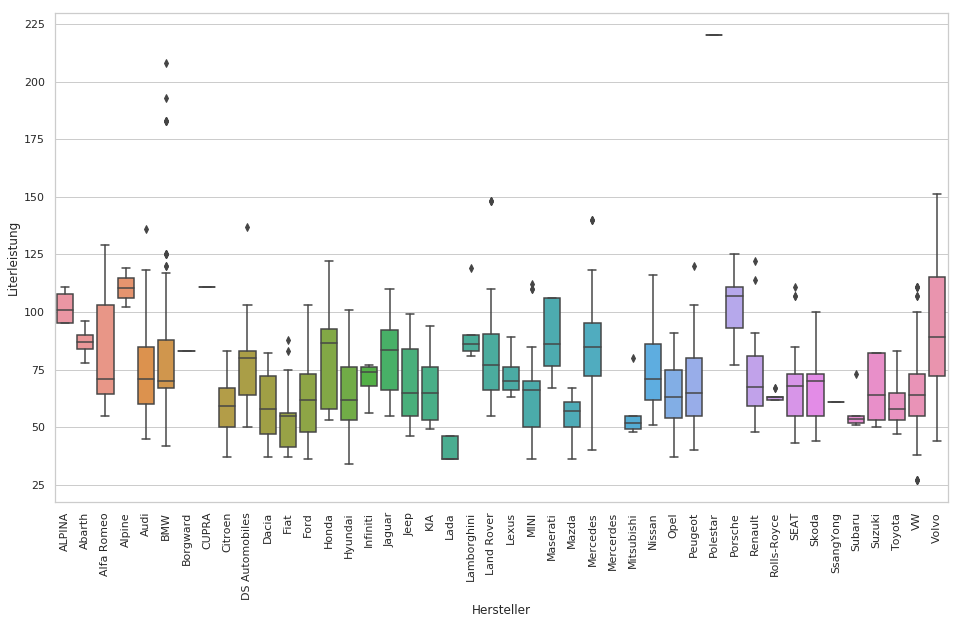

In [299]:
fig, ax = plt.subplots(figsize=(16,9))
sns.boxplot(x="Hersteller", y="Literleistung", data=df, ax=ax)
# sns.swarmplot(x="Hersteller", y="Literleistung", data=df_german.copy(), ax=ax, color=".25")
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

In [300]:
df[df.Hersteller == 'Alpine']

,Hersteller,Modell,Motorart,Hubraum,Leistung,Abgasnorm,Markteinfuehrung,Literleistung
56,Alpine,A110,Otto,1798.0,185,Euro 6d-TEMP,2018-09-01,102.0
57,Alpine,A110S,Otto,1798.0,215,Euro 6d-TEMP-EVAP-ISC,2019-10-01,119.0


In [302]:
df.sort_values(by='Literleistung', ascending=False).head()

,Hersteller,Modell,Motorart,Hubraum,Leistung,Abgasnorm,Markteinfuehrung,Literleistung
2093,Polestar,1,Hybrid,2000.0,441,Euro 6d-TEMP,2019-10-01,220.0
292,BMW,i3s (94 Ah) (inkl. Range Extender),Elektro,647.0,135,Euro 6d-TEMP,2018-04-01,208.0
291,BMW,i3 (94 Ah) (inkl. Range Extender),Elektro,647.0,125,Euro 6d-TEMP,2018-04-01,193.0
528,BMW,i8 Roadster,Hybrid,1499.0,275,Euro 6d-TEMP-EVAP-ISC,2019-07-01,183.0
527,BMW,i8 Roadster,Hybrid,1499.0,275,Euro 6d-TEMP-EVAP,2018-05-01,183.0


In [145]:
from numpy import log
df.Hubraum.apply(lambda x : log(x))

0       7.221105
1       7.221105
2       7.221105
3       7.221105
4       7.221105
          ...   
2869    7.584773
2870    6.906755
2871    6.906755
2872    6.906755
2873    6.906755
Name: Hubraum, Length: 2874, dtype: float64

# Pivot

In [97]:
df.pivot_table(values="Leistung", index="Hersteller", columns="Hubraum", aggfunc="max")

Hubraum,195,647,875,898,988,998,999,1084,1193,1194,...,5000,5038,5204,5461,5980,6166,6417,6498,6592,6749
Hersteller,,,,,,,,,,,,,,,,,,,,,
ALPINA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Abarth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alfa Romeo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alpine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Audi,NaN,NaN,NaN,NaN,NaN,NaN,85.0,NaN,NaN,NaN,...,NaN,NaN,456.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BMW,140.0,135.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,430.0,NaN
Borgward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CUPRA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Citroen,NaN,NaN,NaN,NaN,NaN,53.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Ploting

In [270]:
pd.set_option('plotting.backend', 'altair')

In [271]:
import altair as alt

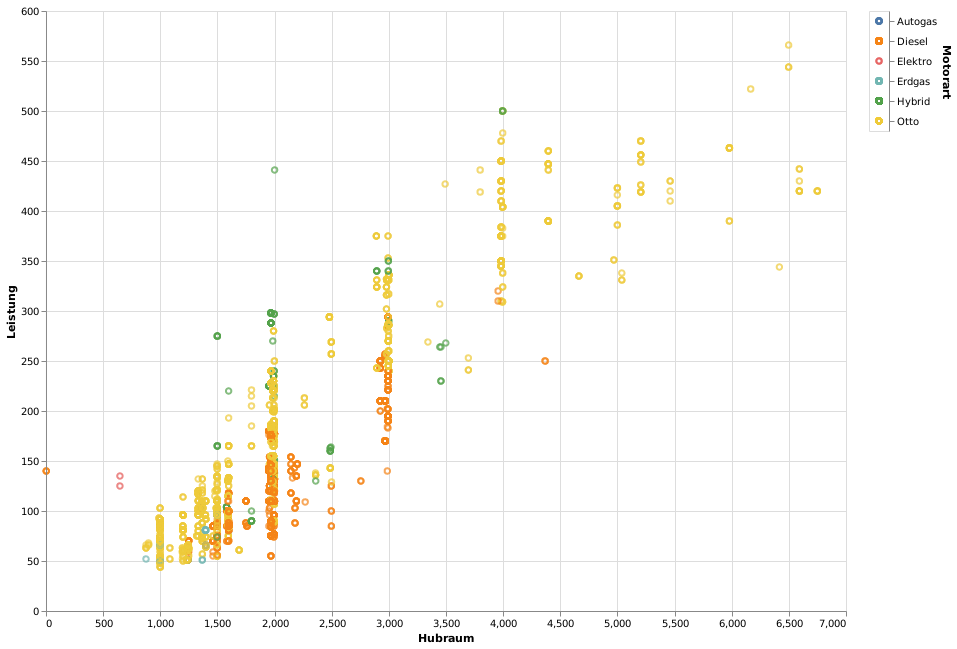

In [272]:
selection = alt.selection_multi(fields=['Motorart'])
color = alt.condition(selection,
                      alt.Color('Motorart:N', legend=None),
                      alt.value('lightgray'))

scatter = alt.Chart(df).mark_point().encode(
    x='Hubraum:Q',
    y='Leistung:Q',
    color=color,
    tooltip='Modell:N'
)

legend = alt.Chart(df).mark_point().encode(
    y=alt.Y('Motorart:N', axis=alt.Axis(orient='right')),
    color=color
).add_selection(
    selection
)

g = scatter | legend

g.configure_view(
    height=600,
    width=800
)

# Groupby operation

In [273]:
g = df.groupby(['Hersteller', 'Hubraum'], sort=True)

In [274]:
dfg = g.aggregate({'Leistung': ['min', 'max']}).dropna()
dfg

Leistung       
                        min    max
Hersteller Hubraum                
ALPINA     2979.0     324.0  332.0
           2993.0     285.0  285.0
           4395.0     447.0  447.0
Abarth     1368.0     107.0  132.0
Alfa Romeo 1368.0      88.0   88.0
...                     ...    ...
VW         2995.0     250.0  250.0
           3956.0     310.0  310.0
Volvo      1477.0     115.0  120.0
           1498.0      90.0  112.0
           1969.0      88.0  298.0

[265 rows x 2 columns]

In [275]:
dfg.loc[('Volvo')]

Leistung       
             min    max
Hubraum                
1477.0     115.0  120.0
1498.0      90.0  112.0
1969.0      88.0  298.0

In [40]:
dfg.loc[('Volvo')].Leistung

,min,max
Hubraum,,
1477,115.0,120.0
1498,90.0,112.0
1969,88.0,298.0


In [41]:
dfg.sample()

Leistung       
                        min    max
Hersteller Hubraum                
Alpine     1798       185.0  215.0

In [18]:
def plot(df):
    selection = alt.selection_multi(fields=['Motorart'])
    color = alt.condition(selection,
                          alt.Color('Motorart:N', legend=None),
                          alt.value('lightgray'))

    scatter = alt.Chart(df).mark_point().encode(
        x='Hubraum:Q',
        y='Leistung:Q',
        color=color,
        tooltip='Modell:N'
    )

    legend = alt.Chart(df).mark_point().encode(
        y=alt.Y('Motorart:N', axis=alt.Axis(orient='right')),
        color=color
    ).add_selection(
        selection
    )

    g = scatter | legend

    g.configure_view(
        height=600,
        width=800
    )
    
    return g

In [19]:
g.head(1).head()

,Hersteller,Modell,Motorart,Hubraum,Leistung,Abgasnorm,Markteinfuehrung
0,Abarth,595,Otto,1368,107,Euro 6d-TEMP-EVAP,2018-09-01
8,Alfa Romeo,Giulia 2.0 Turbo 16V,Otto,1955,147,Euro 6d-TEMP,2018-09-01
12,Alfa Romeo,Giulia 2.2 Diesel,Diesel,2143,118,Euro 6d-TEMP-EVAP,2018-09-01
18,Alfa Romeo,Giulia Quadrifoglio,Otto,2891,375,Euro 6d-TEMP,2018-09-01
20,Alfa Romeo,Giulietta 1.4 TB 16V,Otto,1368,88,Euro 6d-TEMP,2018-11-01


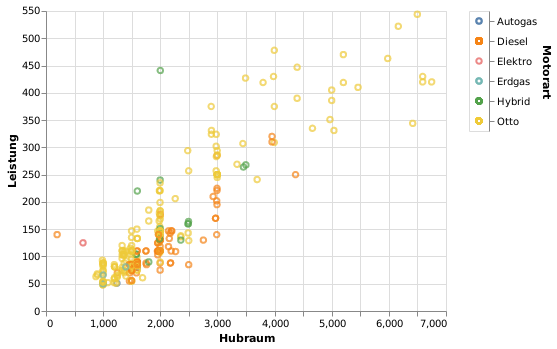

In [20]:
plot(g.head(1))

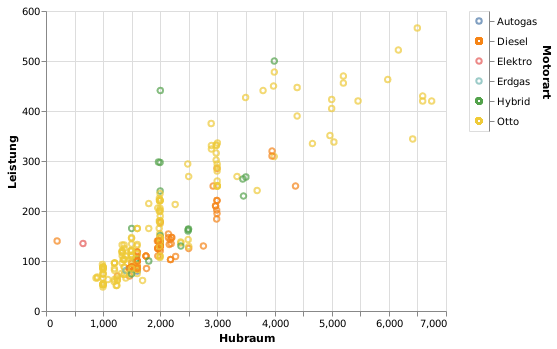

In [104]:
plot(g.tail(1))

In [ ]:
df.groupby('id').filter(lambda g: (g.nunique() > 1).any())

In [78]:
g.filter(lambda a: a.Leistung == a.Leistung.max())

TypeError: filter function returned a Series, but expected a scalar bool

In [65]:
g.groups

{('ALPINA', 2979): Int64Index([35, 36, 37, 38, 39, 40], dtype='int64'),
 ('ALPINA', 2993): Int64Index([45, 46, 47, 48, 52, 53, 54, 55], dtype='int64'),
 ('ALPINA', 4395): Int64Index([41, 42, 43, 44, 49, 50, 51], dtype='int64'),
 ('Abarth', 1368): Int64Index([0, 1, 2, 3, 4, 5, 6, 7], dtype='int64'),
 ('Alfa Romeo', 1368): Int64Index([20], dtype='int64'),
 ('Alfa Romeo', 1598): Int64Index([21], dtype='int64'),
 ('Alfa Romeo', 1955): Int64Index([8, 9, 10, 11], dtype='int64'),
 ('Alfa Romeo', 1956): Int64Index([22], dtype='int64'),
 ('Alfa Romeo', 1995): Int64Index([23, 24, 25, 26], dtype='int64'),
 ('Alfa Romeo',
  2143): Int64Index([12, 13, 14, 15, 16, 17, 27, 28, 29, 30, 31, 32], dtype='int64'),
 ('Alfa Romeo', 2891): Int64Index([18, 19, 33, 34], dtype='int64'),
 ('Alpine', 1798): Int64Index([56, 57], dtype='int64'),
 ('Audi', 999): Int64Index([58, 59, 71, 72, 89, 90, 222, 223], dtype='int64'),
 ('Audi',
  1498): Int64Index([60, 63, 64, 75, 76, 85, 86, 93, 94, 226, 233], dtype='int64'),

In [69]:
g.get_group(('ALPINA', 2979)).Leistung.max

<bound method Series.max of 35    324
36    324
37    324
38    332
39    324
40    332
Name: Leistung, dtype: int64>

In [41]:
df.groupby(['Abgasnorm', 'Hersteller']).size().sort_values()

ValueError: No axis named desc for object type <class 'pandas.core.series.Series'>

In [55]:
df.pivot_table(values='Hubraum in ccm', index='Abgasnorm', columns='Hersteller', aggfunc=len).dropna(axis=1)

Hersteller,ALPINA,Citroen,DSAutomobiles,Mercedes
Abgasnorm,,,,
Euro 6d,5.0,2.0,3.0,6.0
Euro 6d-TEMP,9.0,38.0,7.0,198.0


# Umweltdaten

In [42]:
from bs4 import BeautifulSoup

In [43]:
url = "https://www.adac.de/infotestrat/autodatenbank/autokatalog/baureihe.aspx?hersteller=VW"

# Getting the webpage, creating a Response object.
response = requests.get(url)

# Extracting the source code of the page.
data = response.text

# Passing the source code to BeautifulSoup to create a BeautifulSoup object for it.
soup = BeautifulSoup(data, 'lxml')

# Extracting all the <a> tags into a list.
tags = soup.find_all('a')

In [53]:
df.columns

Index(['Hersteller', 'Modell', 'Motorart', 'Hubraum', 'Leistung', 'Abgasnorm',
       'Markteinfuehrung'],
      dtype='object')

In [54]:
vw = df[df.Hersteller.str.lower() == "vw"]
# Rename columns as in base DataFrame for later join
vw = vw.rename({"Leistung in kW": "kW", "Hubraum in ccm": "ccm"}, axis=1)

In [55]:
vw.sample()

,Hersteller,Modell,Motorart,Hubraum,Leistung,Abgasnorm,Markteinfuehrung
2742,VW,Passat 1.6 TDI SCR,Diesel,1598,88,Euro 6d-TEMP-EVAP-ISC,Aug. 19


In [56]:
models = df.Modell.drop_duplicates()

In [57]:
models.str.split(expand=True)

,0,1,2,3,4,5,6
0,595,None,None,None,None,None,None
1,595,Pista,None,None,None,None,None
2,595,Turismo,None,None,None,None,None
3,595,Competizione,None,None,None,None,None
4,595C,None,None,None,None,None,None
...,...,...,...,...,...,...,...
2864,Touran,1.5,TSI,OPF,ACT,None,None
2866,Touran,2.0,TDI,SCR,None,None,None
2870,up!,1.0,None,None,None,None,None
2872,up!,1.0,TSI,None,None,None,None


In [58]:
res = pd.read_html("https://www.adac.de/infotestrat/autodatenbank/autokatalog/modelle.aspx?baureihe=T6%2bCalifornia&limit=10000")[0]

In [59]:
len(res)

168

In [60]:
res["C02"] = res["C02"].str.replace(" g/km", "")
res["C02"] = res["C02"].astype(int)

In [63]:
url = ("https://www.adac.de/infotestrat/autodatenbank/autokatalog/modelle.aspx?" +
       urlencode({"baureihe" : "+".join("T6 Caravelle 2.0 TDI".split())}))

In [64]:
vw.head()

,Hersteller,Modell,Motorart,Hubraum,Leistung,Abgasnorm,Markteinfuehrung
2615,VW,Arteon 1.5 TSI OPF,Otto,1498,110,Euro 6d-TEMP,Okt. 18
2616,VW,Arteon 2.0 TSI OPF,Otto,1984,140,Euro 6d-TEMP-EVAP,Mai 19
2617,VW,Arteon 2.0 TSI OPF,Otto,1984,140,Euro 6d-TEMP-EVAP-ISC,Jun. 19
2618,VW,Arteon 2.0 TSI OPF,Otto,1984,200,Euro 6d-TEMP-EVAP,Nov. 18
2619,VW,Arteon 2.0 TSI OPF,Otto,1984,200,Euro 6d-TEMP-EVAP-ISC,Jun. 19


## join data on ccm and kW

In [65]:
index = ['ccm', 'kW']

In [66]:
eng_char = res[["Kraftstoff", "kW", "C02", "ccm"]].drop_duplicates()

In [67]:
df_joined = vw.set_index(index).join(eng_char.set_index(index))

KeyError: "None of ['ccm', 'kW'] are in the columns"

In [31]:
df_joined.sample()

,,Hersteller,Modell,Motorart,Abgasnorm,Markt- einführung,Kraftstoff,C02
ccm,kW,,,,,,,
1968,84,VW,T6 Caravelle 2.0 TDI,Diesel,Euro 6d-TEMP,Nov. 18,Diesel,188.0


In [33]:
df_joined.reset_index().dropna()

,ccm,kW,Hersteller,Modell,Motorart,Abgasnorm,Markt- einführung,Kraftstoff,C02
55,1968,75,VW,Caddy 2.0 TDI,Diesel,Euro 6d-TEMP,Okt. 18,Diesel,166.0
56,1968,75,VW,Caddy 2.0 TDI,Diesel,Euro 6d-TEMP,Okt. 18,Diesel,193.0
57,1968,75,VW,Caddy 2.0 TDI,Diesel,Euro 6d-TEMP,Okt. 18,Diesel,187.0
58,1968,75,VW,Caddy Beach 2.0 TDI,Diesel,Euro 6d-TEMP,Okt. 18,Diesel,166.0
59,1968,75,VW,Caddy Beach 2.0 TDI,Diesel,Euro 6d-TEMP,Okt. 18,Diesel,193.0
60,1968,75,VW,Caddy Beach 2.0 TDI,Diesel,Euro 6d-TEMP,Okt. 18,Diesel,187.0
61,1968,75,VW,Caddy Alltrack 2.0 TDI,Diesel,Euro 6d-TEMP,Okt. 18,Diesel,166.0
62,1968,75,VW,Caddy Alltrack 2.0 TDI,Diesel,Euro 6d-TEMP,Okt. 18,Diesel,193.0
63,1968,75,VW,Caddy Alltrack 2.0 TDI,Diesel,Euro 6d-TEMP,Okt. 18,Diesel,187.0
64,1968,75,VW,Caddy Kombi 2.0 TDI,Diesel,Euro 6d-TEMP,Okt. 18,Diesel,166.0


In [42]:
res = pd.read_html(url)

ImportError: html5lib not found, please install it

In [38]:
res[0]

,Vergleich,Vergleich.1,Bezeichnung,Aufbau,Türen,Kraftstoff,kW,C02,ccm,Listenpreis,Details
0,NaN,NaN,VW up! GTI,Schrägheck,3,Super,85,110 g/km,999,17300-,NaN
1,NaN,NaN,VW up! GTI,Schrägheck,5,Super,85,110 g/km,999,17780-,NaN


In [75]:
import requests

headers = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.12; rv:58.0) Gecko/20100101 Firefox/58.0'
}

r = requests.get("https://www.adac.de/infotestrat/autodatenbank/autokosten/suchergebnis.aspx", headers=headers)

In [78]:
r.request.headers

{'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.12; rv:58.0) Gecko/20100101 Firefox/58.0', 'Accept-Encoding': 'gzip, deflate', 'Accept': '*/*', 'Connection': 'keep-alive'}

In [79]:
qsd = pd.read_html(r.content)

ValueError: No tables found